# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In this notebook, we consider preliminary hyperparameter tuning with the following classifiers:
* LinearDiscrimantAnalysis
* LogisticRegression
* RidgeClassifier
* SGDClassifier

5-fold train-test splits with scaling, dimensionality reduction, and resampling have already been preprocessed on the full dataset. The results are visualized and discussed.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Dict, List, Union

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

# classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    SGDClassifier,
)

# inner CV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 6.09 s


In [4]:
# Location of cross validation .feather files
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 119 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [5]:
ALL_CASES = {"ternary"}

METRICS = (
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_)
        .sort_values(by=["model_name"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=["balanced_accuracy", "geometric_mean", "f1", "roc_auc"], ascending=False
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    return df


_ = gc_collect()

time: 116 ms


In [6]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 135 ms


# Models

Thanks to FRILL, we may now use the gamut of binary classifiers.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Class weight parameters are set to address class imbalance. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [7]:
MODELS = {
    "LDA": lambda: LinearDiscriminantAnalysis(),
    "LogReg": lambda: LogisticRegression(
        class_weight="balanced", random_state=SEED, max_iter=150, n_jobs=-1
    ),
    "Ridge": lambda: RidgeClassifier(class_weight="balanced", random_state=SEED),
    "SGD": lambda: SGDClassifier(
        n_jobs=-1,
        random_state=SEED,
        early_stopping=True,
        class_weight="balanced",
    ),
}

PARAMS = {
    "LDA": {"solver": ["eigen", "lsqr", "svd"]},
    "LogReg": [
        {
            "penalty": ["l2"],
            "C": [0.01, 0.1, 1.0, 10.0, 100.0],
            "fit_intercept": [False, True],
            "solver": ["lbfgs", "sag", "saga"],
        },
        {
            "penalty": ["none"],
            "fit_intercept": [False, True],
            "solver": ["lbfgs", "sag", "saga"],
        },
        {
            "penalty": ["elasticnet"],
            "C": [0.01, 0.1, 1.0, 10.0, 100.0],
            "fit_intercept": [False, True],
            "solver": ["saga"],
        },
    ],
    "Ridge": [
        {
            "alpha": [0.2, 0.4, 0.6, 0.8, 1.0],
            "fit_intercept": [False, True],
            "solver": ["auto", "lsqr", "svd"],
        },
        {
            "alpha": [0.2, 0.4, 0.6, 0.8, 1.0],
            "fit_intercept": [False, True],
            "solver": ["lbfgs"],
            "positive": [True],
        },
    ],
    "SGD": {
        "loss": [
            "hinge",
            "log",
            "modified_huber",
            "squared_hinge",
        ],
        "penalty": ["elasticnet", "l2"],
        "alpha": [0.0001, 0.001, 0.01, 0.1],
    },
}

_ = gc_collect()

time: 134 ms


# Test harness

This section defines functions for evaluating models.

In [8]:
def prep_y_pred(label: Union[int, bool], case: str) -> List:
    """Prepares labels for AUROC scoring"""
    if "ternary" in case:
        _ = [0, 0, 0]
        _[int(label)] = 1
        return np.asarray(_, dtype=np.int8)
    else:
        return label


def evaluate_model(
    model_base: str, case: str, track_fold_time: bool = True
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean, roc_auc = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()

        # helper function
        read_feather_cv = lambda _set: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{_set}{'' if _set == 'X_test' else f'_{case[:3]}'}.feather"
        )

        # load training data
        try:
            X_train, y_train = read_feather_cv("X_train"), read_feather_cv(
                "y_train"
            ).astype(np.int8)
        except FileNotFoundError:
            break

        # initialize model
        model = GridSearchCV(
            estimator=MODELS[model_base](),
            param_grid=PARAMS[model_base],
            # RidgeClassifier does not support predict_proba
            scoring="balanced_accuracy"
            if (ridge := model_base == "Ridge")
            else ["balanced_accuracy", "neg_log_loss"],
            n_jobs=-1,
            refit=True if ridge else "neg_log_loss",
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
            verbose=3,
        )

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # save inner CV results
        print(
            f"best validation score for {model_base}: {model.best_score_}",
            model.best_params_,
            sep="\n",
        )
        pd.DataFrame(model.cv_results_).to_csv(
            f"{DATA_OUT_FOLDER}/{model_base}_fold{fold_num}_innerCV_{case}_results.csv"
        )

        # load test data
        X_test = read_feather_cv("X_test")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {
            "y_true": np.squeeze(read_feather_cv("y_test").values).astype(np.int8),
            "y_pred": predicted,
        }
        balanced_accuracy.append(balanced_accuracy_score(**score_params, adjusted=True))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))
        roc_auc.append(
            roc_auc_score(
                y_true=score_params["y_true"],
                y_score=np.stack(
                    pd.Series(score_params["y_pred"]).swifter.apply(
                        prep_y_pred, case=case
                    )
                ),
                average="weighted",
                multi_class="ovo",
            )
        )
        del score_params
        del predicted
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


case = "ternary"

_ = gc_collect()

time: 133 ms


The next cell evaluates models.

In [9]:
model = "LDA"
eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

evaluating LDA...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
fitted in 309.06 s
best validation score for LDA: -0.7389829681841174
{'solver': 'svd'}
predicted in 0.05 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 144223.92it/s]


LDA fold 1 completed in 313.97 s
Fitting 3 folds for each of 3 candidates, totalling 9 fits
fitted in 1028.37 s
best validation score for LDA: -0.7429427215185048
{'solver': 'svd'}
predicted in 0.04 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 195201.30it/s]


LDA fold 2 completed in 1034.72 s
Fitting 3 folds for each of 3 candidates, totalling 9 fits
fitted in 273.98 s
best validation score for LDA: -0.7056006134716261
{'solver': 'svd'}
predicted in 0.05 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 182089.35it/s]


LDA fold 3 completed in 280.61 s
Fitting 3 folds for each of 3 candidates, totalling 9 fits
fitted in 215.66 s
best validation score for LDA: -0.722760016949433
{'solver': 'svd'}
predicted in 0.07 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 180865.95it/s]


LDA fold 4 completed in 222.13 s
Fitting 3 folds for each of 3 candidates, totalling 9 fits
fitted in 291.51 s
best validation score for LDA: -0.6931896037728172
{'solver': 'svd'}
predicted in 0.04 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 155419.45it/s]


LDA fold 5 completed in 297.90 s
stored LDA for ternary classification in 2150.06 s


,model_name,case,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,LDA,ternary,0.330165,0.568002,0.548178,0.661064,423.71792,0.051526


time: 35min 50s


In [10]:
model = "LogReg"
eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

evaluating LogReg...
Fitting 3 folds for each of 46 candidates, totalling 138 fits
fitted in 6094.22 s
best validation score for LogReg: -0.720536142430146
{'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
predicted in 0.43 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 150267.06it/s]


LogReg fold 1 completed in 6101.16 s
Fitting 3 folds for each of 46 candidates, totalling 138 fits
fitted in 6344.34 s
best validation score for LogReg: -0.7259246999547759
{'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
predicted in 0.27 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 171826.58it/s]


LogReg fold 2 completed in 6351.01 s
Fitting 3 folds for each of 46 candidates, totalling 138 fits
fitted in 5933.25 s
best validation score for LogReg: -0.6849682780890382
{'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
predicted in 0.45 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 169472.94it/s]


LogReg fold 3 completed in 5940.05 s
Fitting 3 folds for each of 46 candidates, totalling 138 fits
fitted in 4632.34 s
best validation score for LogReg: -0.703285884463802
{'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
predicted in 0.52 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 152302.64it/s]


LogReg fold 4 completed in 4638.83 s
Fitting 3 folds for each of 46 candidates, totalling 138 fits
fitted in 6033.02 s
best validation score for LogReg: -0.672201836584145
{'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
predicted in 0.35 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 116686.86it/s]


LogReg fold 5 completed in 6039.55 s
stored LogReg for ternary classification in 29071.39 s


,model_name,case,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,LogReg,ternary,0.332704,0.573607,0.548067,0.662231,5807.434518,0.403741
1,LDA,ternary,0.330165,0.568002,0.548178,0.661064,423.717920,0.051526


time: 8h 4min 31s


In [11]:
model = "Ridge"
eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

evaluating Ridge...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
fitted in 2904.67 s
best validation score for Ridge: 0.6885246533347139
{'alpha': 0.4, 'fit_intercept': True, 'solver': 'auto'}
predicted in 0.05 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 157582.44it/s]


Ridge fold 1 completed in 2909.48 s
Fitting 3 folds for each of 40 candidates, totalling 120 fits
fitted in 3223.44 s
best validation score for Ridge: 0.6867746840443946
{'alpha': 0.2, 'fit_intercept': True, 'solver': 'auto'}
predicted in 0.04 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 195567.76it/s]


Ridge fold 2 completed in 3229.40 s
Fitting 3 folds for each of 40 candidates, totalling 120 fits
fitted in 3012.84 s
best validation score for Ridge: 0.7050731858896341
{'alpha': 0.2, 'fit_intercept': True, 'solver': 'auto'}
predicted in 0.08 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 160986.38it/s]


Ridge fold 3 completed in 3019.13 s
Fitting 3 folds for each of 40 candidates, totalling 120 fits
fitted in 2217.49 s
best validation score for Ridge: 0.7009519847542776
{'alpha': 0.2, 'fit_intercept': True, 'solver': 'auto'}
predicted in 0.08 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 144067.27it/s]


Ridge fold 4 completed in 2223.75 s
Fitting 3 folds for each of 40 candidates, totalling 120 fits
fitted in 2885.93 s
best validation score for Ridge: 0.7085980462459743
{'alpha': 0.4, 'fit_intercept': True, 'solver': 'auto'}
predicted in 0.08 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 133710.19it/s]


Ridge fold 5 completed in 2892.37 s
stored Ridge for ternary classification in 14274.91 s


,model_name,case,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,Ridge,ternary,0.333621,0.568958,0.547925,0.662899,2848.872903,0.06651


time: 3h 57min 55s


In [9]:
model = "SGD"
eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

evaluating SGD...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
fitted in 2981.10 s
best validation score for SGD: -0.7891375687592892
{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
predicted in 0.06 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 179462.92it/s]


SGD fold 1 completed in 2987.16 s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
fitted in 3457.67 s
best validation score for SGD: -0.7943150213328293
{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
predicted in 0.05 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 184372.04it/s]


SGD fold 2 completed in 3463.88 s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
fitted in 2785.12 s
best validation score for SGD: -0.761354393844464
{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
predicted in 0.06 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 176096.14it/s]


SGD fold 3 completed in 2791.44 s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
fitted in 1339.87 s
best validation score for SGD: -0.7711594661163496
{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
predicted in 0.08 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 168972.85it/s]


SGD fold 4 completed in 1346.14 s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
fitted in 3492.11 s
best validation score for SGD: -0.7493735407331922
{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
predicted in 0.06 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211502.45it/s]


SGD fold 5 completed in 3498.59 s
stored SGD for ternary classification in 14087.94 s


,model_name,case,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,SGD,ternary,0.326809,0.566105,0.543381,0.658907,2811.174142,0.062513


time: 3h 54min 48s


In [10]:
# save predictions
predictions_df = pd.DataFrame(predictions_)[["model", "case", "fold", "y_pred"]]
predictions_df.case = predictions_df.case.astype("category")
predictions_df.fold = predictions_df.fold.astype(np.uint8)
predictions_df.y_pred = predictions_df.y_pred.swifter.apply(np.int8)
predictions_df.to_feather(f"{DATA_OUT_FOLDER}/initial_tuning_predictions_CV5.feather")
del predictions_df
_ = gc_collect()

Pandas Apply: 100%|██████████| 5/5 [00:00<?, ?it/s]


time: 203 ms


Let's peek at the results.

In [11]:
results_df = create_results_df(results_)
results_df

,model_name,case,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,SGD,ternary,0.326809,0.566105,0.543381,0.658907,2811.174142,0.062513


time: 20.1 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the dimensionality reduction step.

In [12]:
METRIC_NAMES = {
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 115 ms


In [13]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(8)
    g.fig.set_figheight(4)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", y=1, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 162 ms


  0%|          | 0/6 [00:00<?, ?it/s]

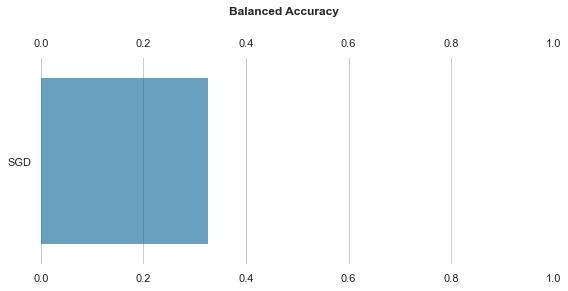

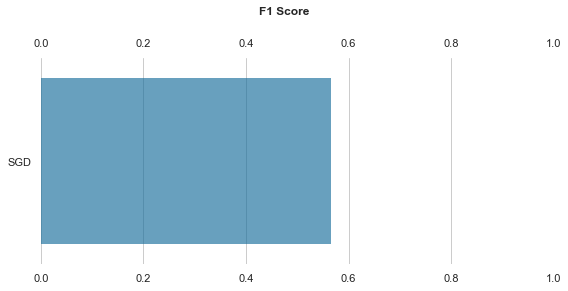

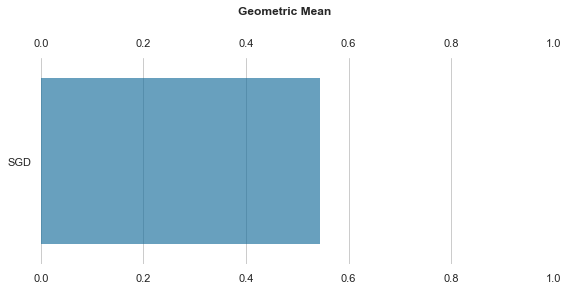

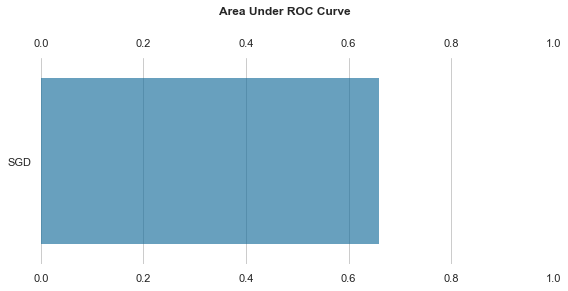

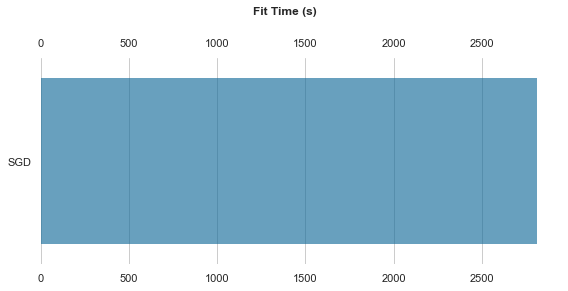

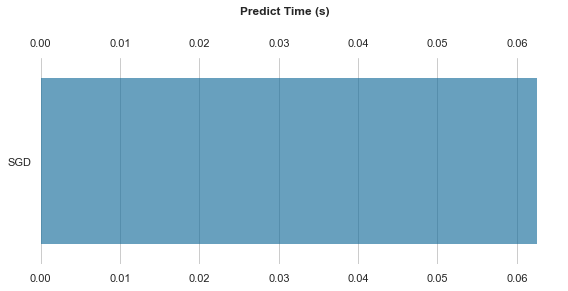

time: 2.58 s


In [14]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [15]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/initial_tuning_results_CV5.csv")

time: 5.02 ms


# Discussion

I underestimated the size of my parameter grids and as a result, initial tuning took a long time. Nonetheless, these results provide an estimate of the expected magnitude of improvement from thorough hyperparameter tuning.

However, higher scores have been obtained on the untransformed data, whereas the data used herein were scaled, reduced in dimension, undersampled, and oversampled to balance class distribution. The preprocessing steps much be more carefully considered.

In [16]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 14128.298686265945 s
time: 123 ms


[^top](#Contents)